f# Semantic Drone Dataset:

The [Semantic Drone Dataset](http://dronedataset.icg.tugraz.at/) focuses on semantic understanding of urban scenes for increasing the safety of autonomous drone flight and landing procedures. The imagery depicts more than 20 houses from nadir (bird's eye) view acquired at an altitude of 5 to 30 meters above ground. A high resolution camera was used to acquire images at a size of 6000x4000px (24Mpx). The training set contains 400 publicly available images and the test set is made up of 200 private images.

![](https://www.tugraz.at/fileadmin/_migrated/pics/fyler3.png)

## Semantic Annotation:

The images are labeled densely using polygons and contain the following 24 classes:

- unlabeled.
- paved-area.
- dirt.
- grass.
- gravel.
- water.
- rocks.
- pool.
- vegetation.
- roof.
- wall.
- window.
- door.
- fence.
- fence-pole.
- person.
- dog.
- car.
- bicycle.
- tree.
- bald-tree.
- ar-marker.
- obstacle.
- conflicting.
  
## Included Data:

- 400 training images.
- Dense semantic annotations in png format can be found in `training_set/gt/semantic/label_images/`.
- Dense semantic annotations as LabelMe xml files can be found in `training_set/gt/semantic/label_me_xml/`.
- Semantic class definition can be found in `training_set/gt/semantic/class_dict.csv`.
- Bounding boxes of persons as LabelMe xml files found in `training_set/gt/bounding_box/label_me_xml`.
- Bounding boxes of persons as mask images found in `training_set/gt/bounding_box/masks`.
- Bounding boxes of individual persons as mask images found in `training_set/gt/bounding_box/masks_instances`.
- Bounding boxes of persons as python pickle file found in `training_set/gt/bounding_box/bounding_boxes/person/`.
    
## License:

The Drone Dataset is made freely available to academic and non-academic entities for non-commercial purposes such as academic research, teaching, scientific publications, or personal experimentation. Permission is granted to use the data given that you agree:

- That the dataset comes "AS IS", without express or implied warranty. Although every effort has been made to ensure accuracy, we (Graz University of Technology) do not accept any responsibility for errors or omissions.
- That you include a reference to the Semantic Drone Dataset in any work that makes use of the dataset. For research papers or other media link to the Semantic Drone Dataset webpage.
- That you do not distribute this dataset or modified versions. It is permissible to distribute derivative works in as far as they are abstract representations of this dataset (such as models trained on it or additional annotations that do not directly include any of our data) and do not allow to recover the dataset or something similar in character.
- That you may not use the dataset or any derivative work for commercial purposes as, for example, licensing or selling the data, or using the data with a purpose to procure a commercial gain.
- That all rights not expressly granted to you are reserved by us (Graz University of Technology).

## Citation:

- http://dronedataset.icg.tugraz.at/.

# What is Semantic Segmentation?:

Semantic segmentation is the task of classifying each and every pixel in an image into a class as shown in the image below. Here we can see that all persons are red, the road is purple, the vehicles are blue, street signs are yellow etc.

![](https://miro.medium.com/max/750/1*RZnBSB3QpkIwFUTRFaWDYg.gif)

Semantic segmentation is different from instance segmentation in that different objects of the same class will have different labels as in person1, person2 and hence different colours.

![](https://cdn.analyticsvidhya.com/wp-content/uploads/2019/02/instanceSegmentation.png)

## Applications:

- **Medical Images:** Automated segmentation of body scans can help doctors to perform diagnostic tests. For example, models can be trained to segment tumors.

![Tumor segmentation of brain MRI scan](https://divamgupta.com/assets/images/posts/imgseg/image3.png?style=centerme)

<center><em>Tumor segmentation of brain MRI scan </em><a href="https://arxiv.org/pdf/1505.03540v3.pdf"><em>Image source</em></a></center>

- **Autonomous Vehicles:** Autonomous vehicles such as self-driving cars and drones can benefit from automated segmentation. For example, self-driving cars can detect drivable regions.

![Segmentation of a road scene](https://divamgupta.com/assets/images/posts/imgseg/image10.png?style=centerme)

<center><em>Segmentation of a road scene </em><a href="https://thegradient.pub/semantic-segmentation/"><em>Image source</em></a></center>

- **Satellite Image Analysis:** Aerial images can be used to segment different types of land. Automated land mapping can also be done.

# Import Libraries and Setup:

In [ ]:
#This notebook performs semantic segmentation on drone imagery using a VGG16-based U-Net architecture with PyTorch.

import os
import sys
import cv2
import random
import pickle
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
from pathlib import Path

import albumentations as A

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import models, transforms
from torchvision.models import VGG16_Weights

print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

#Set device.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

#GPU safety features to prevent overload and crashes.
try:
    if torch.cuda.is_available():
        #Limit GPU memory growth to prevent OOM errors.
        torch.cuda.empty_cache()

        #Set memory allocation strategy to be more conservative.
        torch.backends.cuda.matmul.allow_tf32 = False
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

        #Enable CUDA memory debugging (optional, for monitoring).
        #os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True,garbage_collection_threshold:0.8"

        #Set cudnn to use less memory (may slightly reduce performance but more stable).
        os.environ["CUDNN_AUTOTUNE_THRESHOLD"] = "0"

        print("\nGPU Safety Features Enabled.")
        print(f"Initial GPU memory allocated (MB): {torch.cuda.memory_allocated() / (1024**2):.2f}")
        print(f"Initial GPU memory reserved (MB): {torch.cuda.memory_reserved() / (1024**2):.2f}")

    #Set device with fallback to CPU if GPU runs into issues.
    if device.type == 'cuda':
        #Test GPU with a small operation.
        a = torch.randn(1024, 1024, device=device)
        b = torch.randn(1024, 1024, device=device)
        _ = torch.mm(a, b)
except Exception as e:
    print(f"GPU safety setup encountered an issue: {e}")
    device = torch.device('cpu')
    print("Falling back to CPU.")

#Set random seeds for reproducibility.
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

c:\Users\Xeron\AppData\Local\Programs\Python\Python311\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


PyTorch version: 2.3.0+cpu
Torchvision version: 0.18.0+cpu
CUDA available: False

Using device: cpu


# Data Augmentation with Albumentations:

In [ ]:
transform = A.Compose([
    A.RandomCrop(width=4500, height=3000, p=1.0),
    A.HorizontalFlip(p=1.0),
    A.VerticalFlip(p=1.0),
    A.Rotate(limit=[60, 240], p=1.0, interpolation=cv2.INTER_NEAREST),
    A.RandomBrightnessContrast(brightness_limit=[-0.2, 0.4], contrast_limit=0.2, p=1.0),
    A.OneOf([
        A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.5),
        A.GridDistortion(p=0.5),
        A.OpticalDistortion(distort_limit=1, interpolation=cv2.INTER_NEAREST, p=0.5),
    ], p=1.0),
], p=1.0)

C:\Users\Xeron\AppData\Local\Temp\ipykernel_3868\1006537732.py:10: UserWarning: Argument(s) 'shift_limit' are not valid for transform OpticalDistortion
  A.OpticalDistortion(distort_limit=1, shift_limit=0.5, interpolation=cv2.INTER_NEAREST, p=0.5),


In [3]:
def visualize(image, mask, original_image=None, original_mask=None):
    fontsize = 16

    if original_image is None and original_mask is None:
        f, ax = plt.subplots(2, 1, figsize=(16, 16), squeeze=True)
        f.set_tight_layout(h_pad=5, w_pad=5)

        ax[0].imshow(image)
        ax[1].imshow(mask)
    else:
        f, ax = plt.subplots(2, 2, figsize=(16, 16), squeeze=True)
        plt.tight_layout(pad=0.2, w_pad=1.0, h_pad=0.01)

        ax[0, 0].imshow(original_image)
        ax[0, 0].set_title('Original Image', fontsize=fontsize)

        ax[1, 0].imshow(original_mask)
        ax[1, 0].set_title('Original Mask', fontsize=fontsize)

        ax[0, 1].imshow(image)
        ax[0, 1].set_title('Transformed Image', fontsize=fontsize)

        ax[1, 1].imshow(mask)
        ax[1, 1].set_title('Transformed Mask', fontsize=fontsize)
        
    plt.savefig('./visuals/sample_augmented_comparison.png', facecolor='w', transparent=False, bbox_inches='tight', dpi=100)

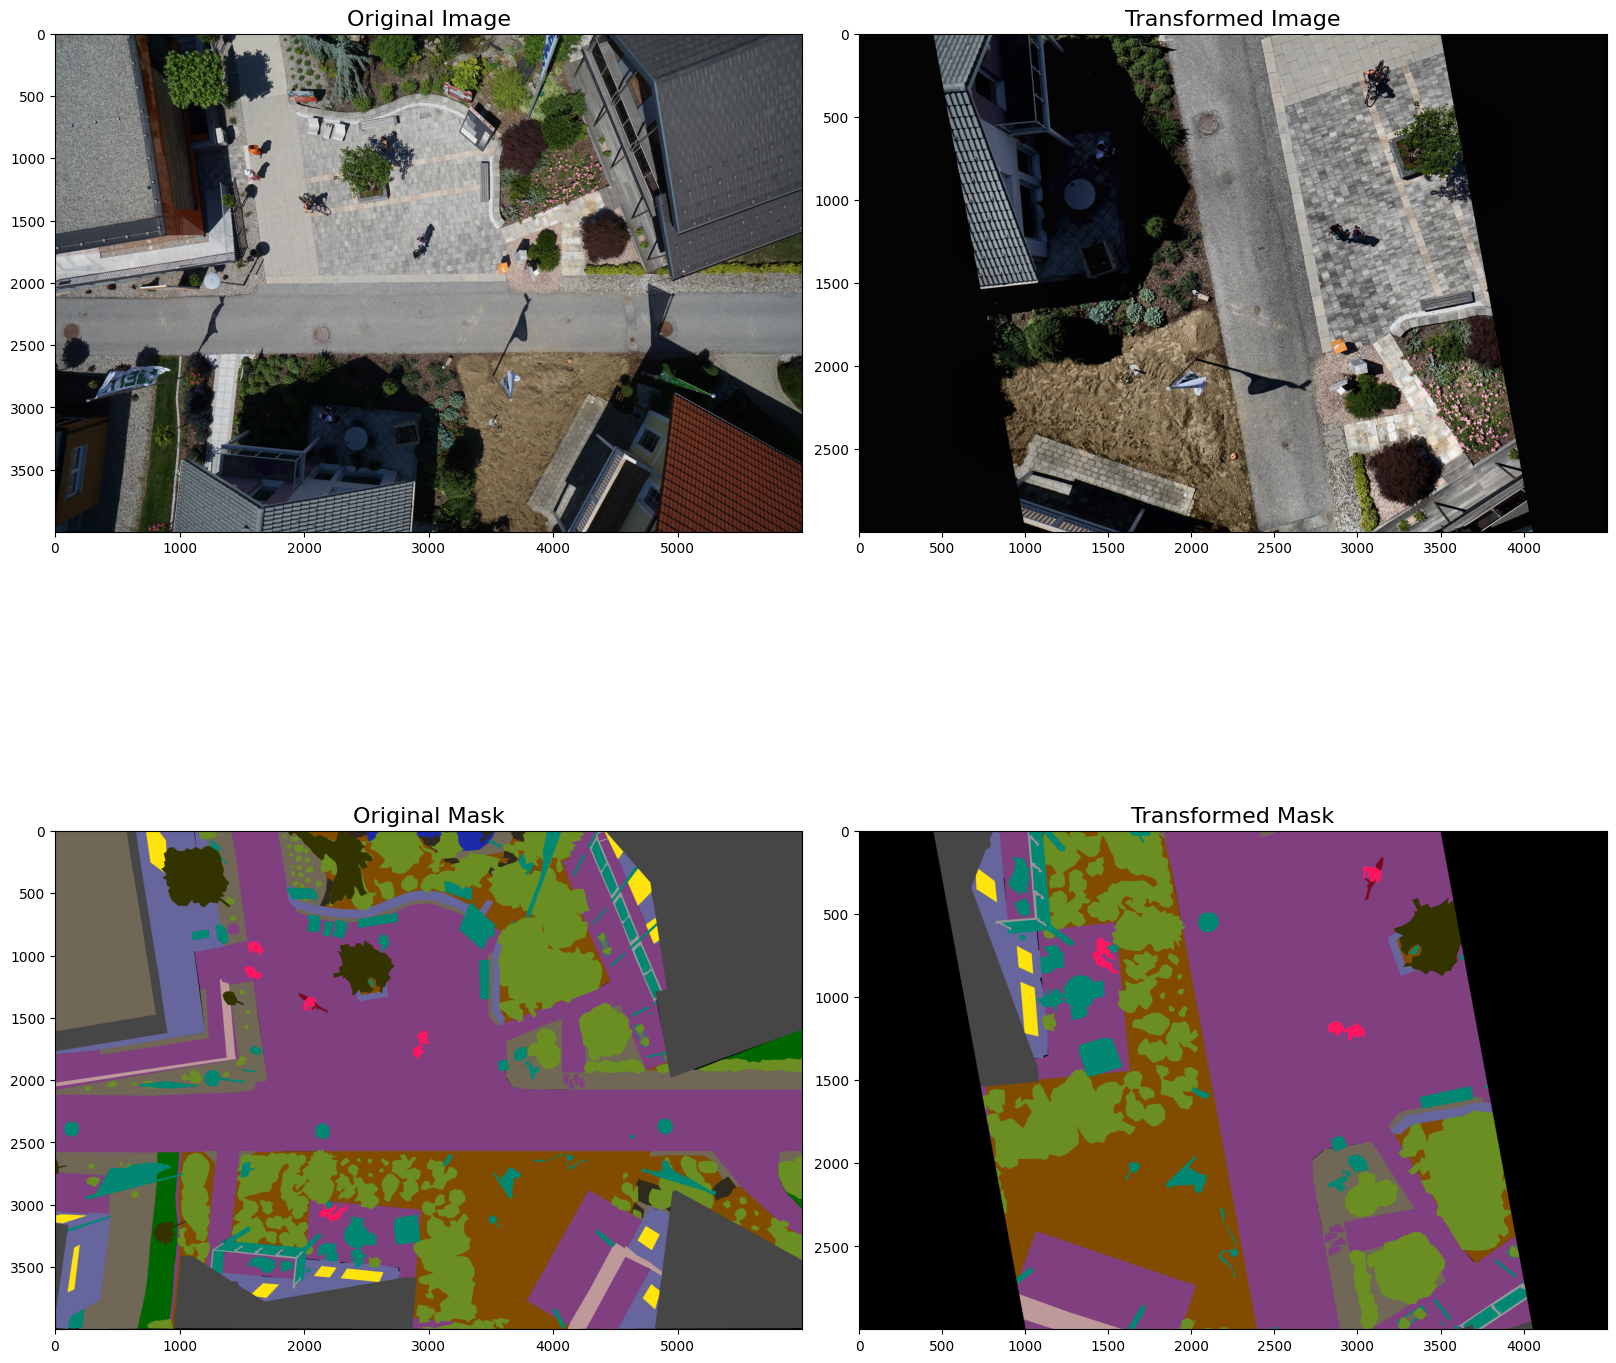

In [ ]:
#Example augmentation visualization.
image_path = "./semantic_drone_dataset/training_set/images/040.jpg"
mask_path = "./semantic_drone_dataset/training_set/gt/semantic/label_images/040.png"

if os.path.exists(image_path) and os.path.exists(mask_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

    transformed = transform(image=image, mask=mask)
    transformed_image = transformed['image']
    transformed_mask = transformed['mask']

    cv2.imwrite('./visuals/augmented_image.png', cv2.cvtColor(transformed_image, cv2.COLOR_BGR2RGB))
    cv2.imwrite('./visuals/augmented_mask.png', cv2.cvtColor(transformed_mask, cv2.COLOR_BGR2RGB))

    visualize(transformed_image, transformed_mask, image, mask)
else:
    print(f"Sample images not found at {image_path} or {mask_path}")

# Load Class Dictionary:

In [5]:
class_dict_path = './semantic_drone_dataset/training_set/gt/semantic/class_dict.csv'
class_dict_df = pd.read_csv(class_dict_path, index_col=False, skipinitialspace=True)
class_dict_df

,name,r,g,b
0,unlabeled,0,0,0
1,paved-area,128,64,128
2,dirt,130,76,0
3,grass,0,102,0
4,gravel,112,103,87
5,water,28,42,168
6,rocks,48,41,30
7,pool,0,50,89
8,vegetation,107,142,35
9,roof,70,70,70


In [6]:
label_names = list(class_dict_df['name'])
label_codes = []
r = np.asarray(class_dict_df['r'])
g = np.asarray(class_dict_df['g'])
b = np.asarray(class_dict_df['b'])

for i in range(len(class_dict_df)):
    label_codes.append(tuple([r[i], g[i], b[i]]))
    
print("First 5 label codes:", label_codes[:5])
print("First 5 label names:", label_names[:5])
print(f"Total number of classes: {len(label_codes)}")

First 5 label codes: [(0, 0, 0), (128, 64, 128), (130, 76, 0), (0, 102, 0), (112, 103, 87)]
First 5 label names: ['unlabeled', 'paved-area', 'dirt', 'grass', 'gravel']
Total number of classes: 24


In [ ]:
#Create useful label & code conversion dictionaries.
code2id = {v: k for k, v in enumerate(label_codes)}
id2code = {k: v for k, v in enumerate(label_codes)}

name2id = {v: k for k, v in enumerate(label_names)}
id2name = {k: v for k, v in enumerate(label_names)}

print("id2code:", id2code)
print("\nid2name:", id2name)

id2code: {0: (0, 0, 0), 1: (128, 64, 128), 2: (130, 76, 0), 3: (0, 102, 0), 4: (112, 103, 87), 5: (28, 42, 168), 6: (48, 41, 30), 7: (0, 50, 89), 8: (107, 142, 35), 9: (70, 70, 70), 10: (102, 102, 156), 11: (254, 228, 12), 12: (254, 148, 12), 13: (190, 153, 153), 14: (153, 153, 153), 15: (255, 22, 96), 16: (102, 51, 0), 17: (9, 143, 150), 18: (119, 11, 32), 19: (51, 51, 0), 20: (190, 250, 190), 21: (112, 150, 146), 22: (2, 135, 115), 23: (255, 0, 0)}

id2name: {0: 'unlabeled', 1: 'paved-area', 2: 'dirt', 3: 'grass', 4: 'gravel', 5: 'water', 6: 'rocks', 7: 'pool', 8: 'vegetation', 9: 'roof', 10: 'wall', 11: 'window', 12: 'door', 13: 'fence', 14: 'fence-pole', 15: 'person', 16: 'dog', 17: 'car', 18: 'bicycle', 19: 'tree', 20: 'bald-tree', 21: 'ar-marker', 22: 'obstacle', 23: 'conflicting'}


# Define Functions for One Hot Encoding RGB Labels and Decoding Encoded Predictions:

In [8]:
def rgb_to_onehot(rgb_image, colormap=id2code):
    '''Function to one hot encode RGB mask labels
        Inputs: 
            rgb_image - image matrix (eg. 256 x 256 x 3 dimension numpy ndarray)
            colormap - dictionary of color to label id
        Output: One hot encoded image of dimensions (height x width x num_classes) where num_classes = len(colormap)
    '''
    num_classes = len(colormap)
    shape = rgb_image.shape[:2] + (num_classes,)
    encoded_image = np.zeros(shape, dtype=np.int8)
    for i, cls in enumerate(colormap):
        encoded_image[:, :, i] = np.all(rgb_image.reshape((-1, 3)) == colormap[i], axis=1).reshape(shape[:2])
    return encoded_image


def onehot_to_rgb(onehot, colormap=id2code):
    '''Function to decode encoded mask labels
        Inputs: 
            onehot - one hot encoded image matrix (height x width x num_classes)
            colormap - dictionary of color to label id
        Output: Decoded RGB image (height x width x 3) 
    '''
    single_layer = np.argmax(onehot, axis=-1)
    output = np.zeros(onehot.shape[:2] + (3,))
    for k in colormap.keys():
        output[single_layer == k] = colormap[k]
    return np.uint8(output)

# Custom PyTorch Dataset Class:

In [ ]:
class DroneDataset(Dataset):
    def __init__(self, images_dir, masks_dir, target_size=(512, 512), augment=False):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.target_size = target_size
        self.augment = augment
        
        #Get all image filenames.
        self.image_files = sorted([f for f in os.listdir(images_dir) if f.endswith('.jpg') or f.endswith('.png')])
        
        #Image normalization transform.
        self.normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        #Load image.
        img_name = self.image_files[idx]
        img_path = os.path.join(self.images_dir, img_name)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        #Load mask.
        mask_name = img_name.replace('.jpg', '.png')
        mask_path = os.path.join(self.masks_dir, mask_name)
        mask = cv2.imread(mask_path)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        
        #Resize.
        image = cv2.resize(image, self.target_size)
        mask = cv2.resize(mask, self.target_size, interpolation=cv2.INTER_NEAREST)
        
        #Convert mask to one-hot encoding.
        mask_encoded = rgb_to_onehot(mask, id2code)
        
        #Convert to tensors.
        image = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0  #(H, W, C) -> (C, H, W).
        image = self.normalize(image)
        
        mask_encoded = torch.from_numpy(mask_encoded).permute(2, 0, 1).float()  #(H, W, C) -> (C, H, W).
        
        return image, mask_encoded

# VGG16-UNet Model Definition:

In [ ]:
#This class implements a VGG16-based U-Net architecture for semantic segmentation.
class VGG16UNet(nn.Module):
    def __init__(self, num_classes=24, pretrained=True):

# Dice Coefficient Metric:

In [11]:
def dice_coefficient(y_pred, y_true, smooth=1.0):
    """Calculate Dice coefficient"""
    y_pred_f = y_pred.flatten()
    y_true_f = y_true.flatten()
    intersection = (y_pred_f * y_true_f).sum()
    return (2. * intersection + smooth) / (y_pred_f.sum() + y_true_f.sum() + smooth)

# Prepare Data Loaders:

In [ ]:
#Update these paths according to your dataset structure.
train_images_dir = './semantic_drone_dataset/training_set/images/'
train_masks_dir = './semantic_drone_dataset/training_set/gt/semantic/label_images/'

#Create datasets.
full_dataset = DroneDataset(train_images_dir, train_masks_dir, target_size=(512, 512))

#Split into train and validation (80-20 split).
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

print(f"Total dataset size: {len(full_dataset)}")
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")

#Original hyperparameters from published results.
batch_size = 8  #Original batch size from paper achieving ~0.87 validation dice.
print(f"\nUsing batch size: {batch_size} (original configuration)")

#Create data loaders with pinned memory for faster GPU transfer.
train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=0,  #Set to 0 to avoid multiprocessing issues on Windows.
    pin_memory=torch.cuda.is_available()  #Faster GPU transfer.
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=0,
    pin_memory=torch.cuda.is_available()  #Faster GPU transfer.
)

print(f"\nNumber of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")

#Clear GPU cache before training.
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print(f"\nGPU memory after data loader setup:")
    print(f"  Allocated: {torch.cuda.memory_allocated(0) / 1024**2:.2f} MB")
    print(f"  Reserved: {torch.cuda.memory_reserved(0) / 1024**2:.2f} MB")

Total dataset size: 400
Training set size: 320
Validation set size: 80

Using batch size: 8 (optimized for CPU safety)

Number of training batches: 40
Number of validation batches: 10


# Initialize Model and Training Components:

In [ ]:
#Initialize model.
model = VGG16UNet(num_classes=24, pretrained=True).to(device)

#Loss function.
criterion = nn.CrossEntropyLoss()

#Optimizer.
initial_lr = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr)

#Learning rate scheduler (exponential decay).
def lr_lambda(epoch):
    return 0.1 ** (epoch / 20)

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

#Print model summary.
print(f"Model initialized on {device}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters())}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\Xeron/.cache\torch\hub\checkpoints\vgg16-397923af.pth
100%|██████████| 528M/528M [05:57<00:00, 1.55MB/s] 



Model initialized on cpu
Total parameters: 25874200
Trainable parameters: 25874200


# Training Function:

In [ ]:
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_dice = 0.0
    
    for batch_idx, (images, masks) in enumerate(train_loader):
        try:
            images = images.to(device)
            masks = masks.to(device)
            
            #Forward pass.
            outputs = model(images)
            
            #Calculate loss.
            loss = criterion(outputs, masks)
            
            #Backward pass and optimization.
            optimizer.zero_grad()
            loss.backward()
            
            #Gradient clipping to prevent exploding gradients.
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            #Calculate dice coefficient.
            with torch.no_grad():
                outputs_softmax = F.softmax(outputs, dim=1)
                dice = dice_coefficient(outputs_softmax, masks)
            
            running_loss += loss.item()
            running_dice += dice.item()
            
            #GPU memory management - clear cache periodically.
            if torch.cuda.is_available() and (batch_idx + 1) % 10 == 0:
                torch.cuda.empty_cache()
            
            if (batch_idx + 1) % 10 == 0:
                print(f"  Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}, Dice: {dice.item():.4f}")
                if torch.cuda.is_available():
                    print(f"    GPU Memory: {torch.cuda.memory_allocated(0) / 1024**2:.2f} MB")
            
            #Free up memory.
            del images, masks, outputs, loss
            
        except RuntimeError as e:
            if "out of memory" in str(e):
                print(f"\nGPU OUT OF MEMORY at batch {batch_idx + 1}.")
                print("Clearing cache and skipping this batch.")
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
                continue
            else:
                raise e
    
    epoch_loss = running_loss / len(train_loader)
    epoch_dice = running_dice / len(train_loader)
    
    return epoch_loss, epoch_dice

# Validation Function:

In [ ]:
def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_dice = 0.0
    
    with torch.no_grad():
        for batch_idx, (images, masks) in enumerate(val_loader):
            try:
                images = images.to(device)
                masks = masks.to(device)
                
                #Forward pass.
                outputs = model(images)
                
                #Calculate loss.
                loss = criterion(outputs, masks)
                
                #Calculate dice coefficient.
                outputs_softmax = F.softmax(outputs, dim=1)
                dice = dice_coefficient(outputs_softmax, masks)
                
                running_loss += loss.item()
                running_dice += dice.item()
                
                #Free up memory.
                del images, masks, outputs, loss
                
                #Clear GPU cache periodically.
                if torch.cuda.is_available() and (batch_idx + 1) % 10 == 0:
                    torch.cuda.empty_cache()
                    
            except RuntimeError as e:
                if "out of memory" in str(e):
                    print(f"\nGPU OUT OF MEMORY during validation at batch {batch_idx + 1}.")
                    print("Clearing cache and skipping this batch.")
                    if torch.cuda.is_available():
                        torch.cuda.empty_cache()
                    continue
                else:
                    raise e
    
    epoch_loss = running_loss / len(val_loader)
    epoch_dice = running_dice / len(val_loader)
    
    return epoch_loss, epoch_dice

# Training Loop:

In [ ]:
def train_loop(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=20, patience=6):
    #Lists to store metrics.
    train_losses = []
    train_dices = []
    val_losses = []
    val_dices = []
    learning_rates = []
    
    #Create directory for saving models.
    os.makedirs('models', exist_ok=True)
    
    best_val_loss = float('inf')
    patience_counter = 0
    
    print("Starting training...\n")
    
    for epoch in range(num_epochs):
        current_lr = optimizer.param_groups[0]['lr']
        learning_rates.append(current_lr)
        
        print(f"Epoch [{epoch + 1}/{num_epochs}], LR: {current_lr:.6f}")
        
        #Train.
        train_loss, train_dice = train_one_epoch(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        train_dices.append(train_dice)
        
        #Validate.
        val_loss, val_dice = validate(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_dices.append(val_dice)
        
        print(f"Train Loss: {train_loss:.4f}, Train Dice: {train_dice:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Dice: {val_dice:.4f}")
        
        #Save best model.
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_dice': train_dice,
                'val_dice': val_dice,
            }, 'models/vgg16_unet_best.pth')
            print(f"Model saved. (Val Loss: {val_loss:.4f})")
        else:
            patience_counter += 1
        
        #Early stopping.
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered after {epoch + 1} epochs")
            break
        
        #Step scheduler.
        scheduler.step()
        print("-" * 80)
    
    print("\nTraining completed.")
    
    return train_losses, train_dices, val_losses, val_dices, learning_rates

Starting training...

Epoch [1/20], LR: 0.000100
  Batch [10/40], Loss: 2.6786, Dice: 0.0872
  Batch [10/40], Loss: 2.6786, Dice: 0.0872


# Save Training History:

In [ ]:
history = {
    'train_loss': train_losses,
    'train_dice': train_dices,
    'val_loss': val_losses,
    'val_dice': val_dices,
    'learning_rate': learning_rates
}

with open('trainHistoryDict.pkl', 'wb') as file:
    pickle.dump(history, file)

#Also save as CSV.
history_df = pd.DataFrame({
    'epoch': range(1, len(train_losses) + 1),
    'train_loss': train_losses,
    'train_dice_coef': train_dices,
    'val_loss': val_losses,
    'val_dice_coef': val_dices,
    'lr': learning_rates
})
history_df.to_csv('model_training_csv.log', index=False)
print("Training history saved.")

# Plot Training Metrics:

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(30, 5))
ax = ax.ravel()
metrics = ['Dice Coefficient', 'Loss', 'Learning Rate']

#Plot Dice Coefficient.
ax[0].plot(train_dices, 'o-', label='Train')
ax[0].plot(val_dices, 'o-', label='Validation')
ax[0].set_title('Dice Coefficient vs Epochs', fontsize=16)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Dice Coefficient')
ax[0].set_xticks(np.arange(0, len(train_dices) + 1, 2))
ax[0].legend()
ax[0].grid(True, color="lightgray", linewidth="0.8", linestyle="-")

#Plot Loss.
ax[1].plot(train_losses, 'o-', label='Train')
ax[1].plot(val_losses, 'o-', label='Validation')
ax[1].set_title('Loss vs Epochs', fontsize=16)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].set_xticks(np.arange(0, len(train_losses) + 1, 2))
ax[1].legend()
ax[1].grid(True, color="lightgray", linewidth="0.8", linestyle="-")

#Plot Learning Rate.
ax[2].plot(learning_rates, 'o-')
ax[2].set_title('Learning Rate vs Epochs', fontsize=16)
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Learning Rate')
ax[2].set_xticks(np.arange(0, len(learning_rates) + 1, 2))
ax[2].grid(True, color="lightgray", linewidth="0.8", linestyle="-")

plt.savefig('./visuals/model_metrics_plot.png', facecolor='w', transparent=False, bbox_inches='tight', dpi=150)
plt.show()

# Load Best Model for Predictions:

In [ ]:
#Load best model.
checkpoint = torch.load('models/vgg16_unet_best.pth', map_location=device, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
print(f"Best model loaded from epoch {checkpoint['epoch'] + 1}")
print(f"Val Loss: {checkpoint['val_loss']:.4f}, Val Dice: {checkpoint['val_dice']:.4f}")

# Generate Predictions:

In [ ]:
#Create predictions directory.
os.makedirs('./visuals/predictions', exist_ok=True)

model.eval()
count = 0

with torch.no_grad():
    for batch_idx, (batch_img, batch_mask) in enumerate(val_loader):
        if batch_idx >= 10:  #Generate predictions for first 10 batches.
            break
        
        batch_img = batch_img.to(device)
        batch_mask = batch_mask.to(device)
        
        #Predict.
        pred_all = model(batch_img)
        pred_all = F.softmax(pred_all, dim=1)
        
        #Move to CPU and convert to numpy.
        batch_img = batch_img.cpu().numpy()
        batch_mask = batch_mask.cpu().numpy()
        pred_all = pred_all.cpu().numpy()
        
        for j in range(batch_img.shape[0]):
            count += 1
            
            #Denormalize image for display.
            img_display = batch_img[j].transpose(1, 2, 0)
            img_display = img_display * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            img_display = np.clip(img_display, 0, 1)
            
            #Convert masks to RGB.
            true_mask_rgb = onehot_to_rgb(batch_mask[j].transpose(1, 2, 0), id2code)
            pred_mask_rgb = onehot_to_rgb(pred_all[j].transpose(1, 2, 0), id2code)
            
            #Plot.
            fig = plt.figure(figsize=(20, 8))
            
            ax1 = fig.add_subplot(1, 3, 1)
            ax1.imshow(img_display)
            ax1.set_title('Original Image')
            ax1.grid(False)
            ax1.axis('off')
            
            ax2 = fig.add_subplot(1, 3, 2)
            ax2.imshow(true_mask_rgb)
            ax2.set_title('Ground Truth Mask')
            ax2.grid(False)
            ax2.axis('off')
            
            ax3 = fig.add_subplot(1, 3, 3)
            ax3.imshow(pred_mask_rgb)
            ax3.set_title('Predicted Mask')
            ax3.grid(False)
            ax3.axis('off')
            
            plt.savefig(f'./visuals/predictions/prediction_{count}.png', facecolor='w', transparent=False, bbox_inches='tight', dpi=200)
            plt.close()
            
            if count >= 80:  #Limit to 80 predictions.
                break
        
        if count >= 80:
            break

print(f"Generated {count} predictions in './visuals/predictions/' directory")

# Display Sample Predictions:

In [ ]:
#Display a few sample predictions.
model.eval()

with torch.no_grad():
    #Get one batch.
    batch_img, batch_mask = next(iter(val_loader))
    batch_img = batch_img.to(device)
    batch_mask = batch_mask.to(device)
    
    #Predict.
    pred = model(batch_img)
    pred = F.softmax(pred, dim=1)
    
    #Move to CPU.
    batch_img = batch_img.cpu().numpy()
    batch_mask = batch_mask.cpu().numpy()
    pred = pred.cpu().numpy()
    
    #Display first 3 images.
    for i in range(min(3, batch_img.shape[0])):
        #Denormalize image.
        img_display = batch_img[i].transpose(1, 2, 0)
        img_display = img_display * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img_display = np.clip(img_display, 0, 1)
        
        #Convert masks to RGB.
        true_mask_rgb = onehot_to_rgb(batch_mask[i].transpose(1, 2, 0), id2code)
        pred_mask_rgb = onehot_to_rgb(pred[i].transpose(1, 2, 0), id2code)
        
        #Plot.
        fig = plt.figure(figsize=(20, 8))
        
        ax1 = fig.add_subplot(1, 3, 1)
        ax1.imshow(img_display)
        ax1.set_title('Original Image', fontsize=16)
        ax1.grid(False)
        ax1.axis('off')
        
        ax2 = fig.add_subplot(1, 3, 2)
        ax2.imshow(true_mask_rgb)
        ax2.set_title('Ground Truth Mask', fontsize=16)
        ax2.grid(False)
        ax2.axis('off')
        
        ax3 = fig.add_subplot(1, 3, 3)
        ax3.imshow(pred_mask_rgb)
        ax3.set_title('Predicted Mask', fontsize=16)
        ax3.grid(False)
        ax3.axis('off')
        
        plt.show()

# Save Final Summary:

In [ ]:
print("\nTRAINING SUMMARY")
print(f"Framework: PyTorch {torch.__version__}")
print(f"Device: {device}")
print(f"Total epochs: {len(train_losses)}")
print(f"Best validation loss: {min(val_losses):.4f}")
print(f"Best validation dice: {max(val_dices):.4f}")
print(f"Final training loss: {train_losses[-1]:.4f}")
print(f"Final training dice: {train_dices[-1]:.4f}")
print(f"Final validation loss: {val_losses[-1]:.4f}")
print(f"Final validation dice: {val_dices[-1]:.4f}")
print("\nModel saved at: models/vgg16_unet_best.pth")
print("Training history saved at: model_training_csv.log")
print("Predictions saved in: ./visuals/predictions/")
print("Training metrics plot saved at: ./visuals/model_metrics_plot.png")
print("Repository: https://github.com/WhiteMetagross/SemanticSegmentationDroneImagesPyTorch")